In [ ]:
pip install rrcf

  Created wheel for rrcf: filename=rrcf-0.4.3-cp36-none-any.whl size=9811 sha256=101caac34e6ca88fcf1b9e0a430b24bd42bb24145a601ec5d9b718bb222f89e3
  Stored in directory: /root/.cache/pip/wheels/6c/7c/b7/8983591821eb2c00a31795b29232dcedc4d7fad70a6c663870
Successfully built rrcf


In [ ]:
import numpy as np
import rrcf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import files
files=files.upload()

Saving dec3.csv to dec3.csv


In [ ]:
df = pd.read_csv('dec3.csv')

In [ ]:
bandwidth = df['bandwidth(MBps)']
arr1 = bandwidth[4099:14099]
arr1 = arr1.dropna()

In [ ]:
arr1 = arr1.to_numpy()
arr1 = arr1.reshape(-1, 1)
min_max_scaler = MinMaxScaler()
arr1 = min_max_scaler.fit_transform(arr1)
arr1 = arr1.reshape(-1,1)

In [ ]:
bandwidth = pd.DataFrame(data = arr1)

In [ ]:
bandwidth['time'] = df['time']

In [ ]:
# Set tree parameters
num_trees = 100
shingle_size = 1
tree_size = 128


# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

# Create a dict to store anomaly score of each point
avg_codisp = {}
    
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(arr1, size=shingle_size)

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

In [ ]:
df1 = pd.DataFrame.from_dict(avg_codisp,orient ='index')
df1.quantile(0.98)

0    21.859224
Name: 0.98, dtype: float64

In [ ]:
bandwidth['CoDisp']= df1
bandwidth.head()

In [ ]:
list1 = bandwidth['CoDisp']>25
bandwidth['Anomaly']=list1
bandwidth.head()

,0,time,CoDisp,Anomaly
0,0.977539,NaN,0.00,False
1,0.991937,NaN,1.00,False
2,0.990750,NaN,1.00,False
3,0.990553,NaN,1.00,False
4,0.992334,NaN,1.65,False


In [ ]:
bandwidth.columns = ['bandwidth(MBps)','Time','CoDisp','Anomaly']

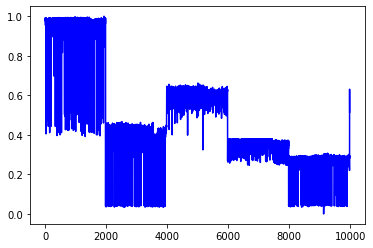

In [ ]:
import matplotlib.pyplot as plt
a = np.arange(0,len(bandwidth))
plt.plot(a,bandwidth['bandwidth(MBps)'],'b')

In [ ]:
anomaly={}
for index, row in bandwidth.iterrows():
  if row['Anomaly'] == True:
    anomaly[index] = row['bandwidth(MBps)']

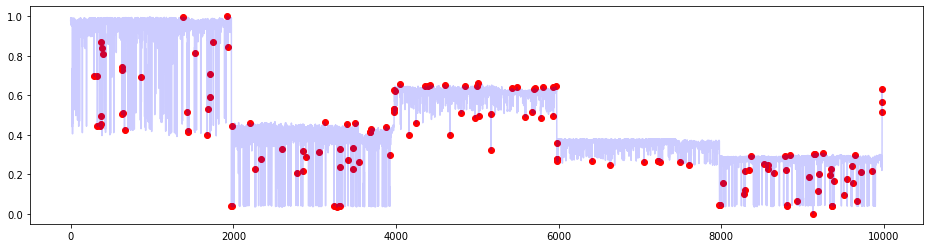

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(a,bandwidth['bandwidth(MBps)'],'b',alpha=0.2)
for key in anomaly:
    plt.scatter(key, anomaly[key],color='red')


In [ ]:
#bandwidth.to_csv('bandwidth.csv')
#from google.colab import files
#files.download("bandwidth.csv")

In [ ]:
df['time'] = pd.to_datetime(df['time'])
df.head()

In [ ]:
test = df[(df['time'] > '2020-11-22 23:00:00') & (df['time'] < '2020-11-22 23:06:00')]

In [ ]:
bw = test['bandwidth(MBps)']
bw = bw.dropna()
bw = bw.to_numpy()

In [ ]:
len(bw)

217

In [ ]:
codisp=[]
test_tree = rrcf.RCTree()
for i in range(len(arr1)):
  test_tree.insert_point(arr1[i],index=i)
  codisp.append(test_tree.codisp(i))


In [ ]:
test_codisp=[]
for i in range(len(bw)):
  test_tree.insert_point(bw[i],index = i + len(arr1))
  test_codisp.append(test_tree.codisp(i+len(arr1)))

In [ ]:
test_codisp1 = pd.DataFrame(data=test_codisp)
test_codisp1.quantile(0.95)

0    1663.333333
Name: 0.95, dtype: float64

In [ ]:
anomaly={}
i=0
for num in test_codisp:
  if num>1663:
    anomaly[i] = num
  i = i+1
anomaly

{0: 9980.0,
 1: 4990.0,
 2: 3326.6666666666665,
 3: 2495.0,
 4: 1996.0,
 5: 1663.3333333333333,
 13: 9980.0,
 18: 4990.0,
 21: 3326.6666666666665,
 60: 2495.0,
 85: 1996.0,
 90: 1663.3333333333333}

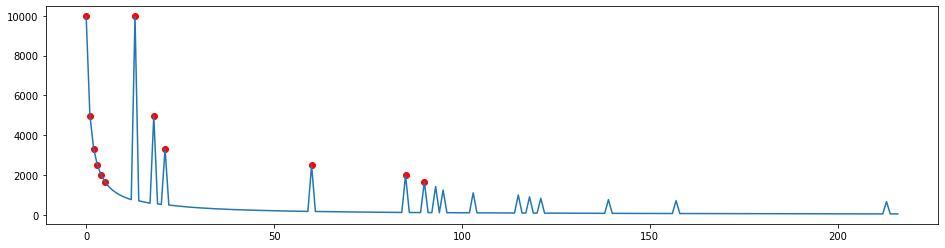

In [ ]:
x = np.arange(len(bw))
plt.figure(figsize=(16,4))
plt.plot(x,test_codisp)
for key in anomaly:
    plt.scatter(key, anomaly[key],color='red')